# Explore Integrated People with Air Theme 1
Look at ANOVAs and descriptive statistics for joined data

## Description of Program
- program:    ip1_3bv1_peopleair
- task:       Explore integrated people and air data
- Version:    2025-12-19
- project:    Southeast Texas Urban Integrated Field Lab
- funding:	  DOE
- author:     Nathanael Rosenheim

## Step 0: Good Housekeeping

In [27]:
# 1. Import all packages
import pandas as pd     # For obtaining and cleaning tabular data
import geopandas as gpd # For obtaining and cleaning spatial data
import matplotlib.pyplot as plt # For plotting
import contextily as ctx # For adding basemaps
import numpy as np
from scipy import stats
import os # For saving output to path
import zipfile # For handling zip files
import io # For handling in-memory data
import requests # For downloading data
import rasterio # For reading geotiff files

In [4]:
# 2. Check versions
import sys
print("Python Version     ", sys.version)
print("geopandas version: ", gpd.__version__)

Python Version      3.13.9 | packaged by conda-forge | (main, Oct 22 2025, 23:12:41) [MSC v.1944 64 bit (AMD64)]
geopandas version:  1.1.1


In [5]:
# 3. Check working directory
# Get information on current working directory (getcwd)
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\GitHub\\integrate_people_theme1_cookbook'

In [6]:
#4. Store Program Name for output files to have the same name
programname = "ip1_3bv1_peopleair"
# Make directory to save output
if not os.path.exists(programname):
    os.mkdir(programname)

# Step 1: Obtain Data
Obtain data from clean data step

In [7]:
# read in cleaned air data from ip1_2av1_convertairtocsv
source_programname = "ip1_2av1_joinpeopleair"
source_filename = f"{source_programname}.csv"

hua_ari_df = pd.read_csv(os.path.join(source_programname, source_filename))


C:\Users\nathanael99\AppData\Local\Temp\ipykernel_25348\2341540361.py:5: DtypeWarning: Columns (20,23,32) have mixed types. Specify dtype option on import or set low_memory=False.
  hua_ari_df = pd.read_csv(os.path.join(source_programname, source_filename))


In [8]:
hua_ari_df.head(1)

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,uifl_4km_Xylenes_p98,uifl_4km_Xylenes_mean,uifl_4km_Xylenes_p75,uifl_4km_Xylenes_p25,uifl_4km_Xylenes_p90,uifl_4km_Xylenes_p95,Household Income Group,Tenure Status,Low Income Renter Status,Race Ethnicity
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,0.061573,0.011893,0.015375,0.001948,0.029066,0.04408,NaN,NaN,NaN,NaN


In [9]:
# print all columns in hua_ari_df
for col in hua_ari_df.columns:
    print(col)

huid
Block2020
blockid
bgid
tractid
FIPScounty
numprec
ownershp
race
hispan
family
vacancy
gqtype
incomegroup
hhinc
randincome
poverty
placeNAME20
x
y
occtype
geometry
Site_ID
Site_Name
TRACT2020
CDCSVI_TRACT
HRRCSVI_TRACT
SVInsight_TRACT
BG2020
HRRCSVI_BG
SVInsight_BG
index__1km
air_grid_id_left
row_idx_left
col_idx_left
uifl_1km_Benzene_p75
uifl_1km_Benzene_p100
uifl_1km_Benzene_p95
uifl_1km_Benzene_p50
uifl_1km_Benzene_p25
uifl_1km_Benzene_p98
uifl_1km_Benzene_p90
uifl_1km_Benzene_mean
uifl_1km_Benzene_p99
uifl_1km_Acetonitrile_p90
uifl_1km_Acetonitrile_p98
uifl_1km_Acetonitrile_mean
uifl_1km_Acetonitrile_p50
uifl_1km_Acetonitrile_p75
uifl_1km_Acetonitrile_p99
uifl_1km_Acetonitrile_p25
uifl_1km_Acetonitrile_p95
uifl_1km_Acetonitrile_p100
uifl_1km_1,3-Butadiene_p100
uifl_1km_1,3-Butadiene_p90
uifl_1km_1,3-Butadiene_p98
uifl_1km_1,3-Butadiene_p95
uifl_1km_1,3-Butadiene_p75
uifl_1km_1,3-Butadiene_mean
uifl_1km_1,3-Butadiene_p50
uifl_1km_1,3-Butadiene_p25
uifl_1km_1,3-Butadiene_p99
uifl

# Step 2: Clean Data

# Step 3: Explore Data

In [26]:
def bootstrap_cohens_d(data1, data2, n_bootstrap=1000, random_state=42):
    """Calculate bootstrap 95% CI for Cohen's d"""
    np.random.seed(random_state)
    n1, n2 = len(data1), len(data2)
    
    cohens_d_bootstrap = []
    for _ in range(n_bootstrap):
        # Resample with replacement
        sample1 = np.random.choice(data1, size=n1, replace=True)
        sample2 = np.random.choice(data2, size=n2, replace=True)
        
        # Calculate pooled standard deviation
        pooled_std = np.sqrt(((n1 - 1) * np.var(sample1, ddof=1) + 
                            (n2 - 1) * np.var(sample2, ddof=1)) / (n1 + n2 - 2))
        
        if pooled_std > 0:
            d = (np.mean(sample1) - np.mean(sample2)) / pooled_std
            cohens_d_bootstrap.append(d)
    
    if len(cohens_d_bootstrap) > 0:
        ci_low = np.percentile(cohens_d_bootstrap, 2.5)
        ci_high = np.percentile(cohens_d_bootstrap, 97.5)
        return ci_low, ci_high
    else:
        return np.nan, np.nan

def calculate_comparison_statistics(data1, data2, n_bootstrap=1000, random_state=42):
    """Calculate comprehensive comparison statistics between two datasets
    
    Parameters:
    - data1, data2: Arrays of numeric data to compare
    - n_bootstrap: Number of bootstrap samples for confidence intervals
    - random_state: Random seed for reproducibility
    
    Returns:
    - Dictionary with statistical results
    """
    if len(data1) == 0 or len(data2) == 0:
        return {
            'n1': len(data1),
            'n2': len(data2),
            'mean1': np.nan,
            'mean2': np.nan,
            'std1': np.nan,
            'std2': np.nan,
            'f_statistic': np.nan,
            'p_value': np.nan,
            'cohens_d': np.nan,
            'ci_low': np.nan,
            'ci_high': np.nan,
            'effect_size': 'insufficient_data',
            'welch_p': np.nan,
            'levene_p': np.nan
        }
    
    # Basic descriptive statistics
    n1, n2 = len(data1), len(data2)
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    std1 = np.std(data1, ddof=1)
    std2 = np.std(data2, ddof=1)
    
    # Run one-way ANOVA
    f_statistic, p_value = stats.f_oneway(data1, data2)
    
    # Calculate Cohen's d
    pooled_std = np.sqrt(((n1 - 1) * np.var(data1, ddof=1) + 
                        (n2 - 1) * np.var(data2, ddof=1)) / (n1 + n2 - 2))
    
    if pooled_std > 0:
        cohens_d = (mean1 - mean2) / pooled_std
        
        # Bootstrap confidence interval for Cohen's d
        ci_low, ci_high = bootstrap_cohens_d(data1, data2, n_bootstrap, random_state)
        
        # Interpretation of effect size
        if abs(cohens_d) < 0.2:
            effect_size_interpretation = "negligible"
        elif abs(cohens_d) < 0.5:
            effect_size_interpretation = "small"
        elif abs(cohens_d) < 0.8:
            effect_size_interpretation = "medium"
        else:
            effect_size_interpretation = "large"
    else:
        cohens_d = np.nan
        ci_low, ci_high = np.nan, np.nan
        effect_size_interpretation = "undefined"
    
    # Levene's test for equal variances and Welch's t-test if needed
    levene_stat, levene_p = stats.levene(data1, data2)
    
    if levene_p < 0.05:
        # Run Welch's t-test as alternative
        welch_stat, welch_p = stats.ttest_ind(data1, data2, equal_var=False)
    else:
        welch_stat, welch_p = np.nan, np.nan
    
    return {
        'n1': n1,
        'n2': n2,
        'mean1': mean1,
        'mean2': mean2,
        'std1': std1,
        'std2': std2,
        'f_statistic': f_statistic,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'effect_size': effect_size_interpretation,
        'welch_p': welch_p,
        'levene_p': levene_p
    }


In [28]:
# Function to compare 1km vs 4km resolution values for any species across multiple percentiles
def compare_resolution_anova(hua_ari_df, 
                             species_name, 
                             percentiles=['p90'], 
                             matched_cases_only=False, 
                             verbose=True):
    """
    Compare 1km and 4km resolution values for one or more species using ANOVA across multiple percentiles
    
    Parameters:
    - hua_ari_df: DataFrame with air pollution and housing data
    - species_name: Name of the species to analyze (e.g., 'Benzene', 'NOx', 'PM2.5') or list of species
    - percentiles: List of percentiles to analyze (e.g., ['p25','p50','p75','p90','p95','p99','p100'])
    - matched_cases_only: If True, only compare housing units that have valid data in both resolutions
    - verbose: If True, print detailed statistical output for each percentile
    
    Returns:
    - results_df: DataFrame with statistical results for all species and percentiles
    """

    
    # Convert single species to list for uniform processing
    if isinstance(species_name, str):
        species_list = [species_name]
    else:
        species_list = list(species_name)

    
    # Initialize results list
    all_results = []
    
    if verbose:
        print(f"\n=== MULTI-SPECIES RESOLUTION COMPARISON ANALYSIS ===")
        print(f"Species: {species_list}")
        print(f"Analysis type: {'Matched cases' if matched_cases_only else 'All available data'}")
        print(f"Percentiles: {percentiles}")
        print(f"Note: Zero values excluded as they represent areas outside the pollution model domain")
    
    # Loop through each species
    for current_species in species_list:
        if verbose:
            print(f"\n" + "="*80)
            print(f"PROCESSING SPECIES: {current_species.upper()}")
            print(f"="*80)
        
        results_list = []
        
        for percentile in percentiles:
            # Define column names
            col_1km = f'uifl_1km_{current_species}_{percentile}'
            col_4km = f'uifl_4km_{current_species}_{percentile}'
            
            # Check if columns exist
            if col_1km not in hua_ari_df.columns or col_4km not in hua_ari_df.columns:
                if verbose:
                    print(f"\nSkipping {current_species} {percentile}: One or both columns not found:")
                    print(f"  {col_1km}: {'Found' if col_1km in hua_ari_df.columns else 'NOT FOUND'}")
                    print(f"  {col_4km}: {'Found' if col_4km in hua_ari_df.columns else 'NOT FOUND'}")
                continue
            
            # Prepare data for analysis
            if matched_cases_only:
                # Only include cases that have valid data in both resolutions
                valid_both = (hua_ari_df[col_1km] > 0) & (hua_ari_df[col_4km] > 0) & \
                            hua_ari_df[col_1km].notna() & hua_ari_df[col_4km].notna()
                
                analysis_df = hua_ari_df[valid_both][[col_1km, col_4km]].copy()
                data_1km = analysis_df[col_1km].values
                data_4km = analysis_df[col_4km].values
                
                analysis_type = "Matched cases"
                sample_description = f"{len(data_1km):,} matched housing units"
                
            else:
                # Independent filtering for each resolution
                data_1km = hua_ari_df[hua_ari_df[col_1km] > 0][col_1km].dropna().values
                data_4km = hua_ari_df[hua_ari_df[col_4km] > 0][col_4km].dropna().values
                
                analysis_type = "All available data"
                sample_description = f"1km: {len(data_1km):,}, 4km: {len(data_4km):,} housing units"
            
            if verbose:
                print(f"\n" + "="*60)
                print(f"ANALYSIS - {current_species.upper()} {percentile.upper()} 1KM vs 4KM RESOLUTION")
                print(f"="*60)
                print(f"Sample: {sample_description}")
            
            # Calculate comprehensive statistics using generic function
            stats_results = calculate_comparison_statistics(data_1km, data_4km)
            
            if verbose and stats_results['n1'] > 0 and stats_results['n2'] > 0:
                print(f"\n--- Descriptive Statistics for {current_species} {percentile} by Resolution ---")
                print(f"1km Resolution (n={stats_results['n1']:,}):")
                print(f"  Mean: {stats_results['mean1']:.4f} ppb")
                print(f"  Std:  {stats_results['std1']:.4f} ppb")
                
                print(f"4km Resolution (n={stats_results['n2']:,}):")
                print(f"  Mean: {stats_results['mean2']:.4f} ppb")
                print(f"  Std:  {stats_results['std2']:.4f} ppb")
                
                print(f"\n--- Statistical Results ---")
                print(f"ANOVA F-statistic: {stats_results['f_statistic']:.4f}, p-value: {stats_results['p_value']:.6f}")
                print(f"Cohen's d: {stats_results['cohens_d']:.4f} ({stats_results['effect_size']})")
                print(f"Cohen's d 95% CI: [{stats_results['ci_low']:.4f}, {stats_results['ci_high']:.4f}]")
                print(f"Levene's p-value: {stats_results['levene_p']:.6f} ({'Unequal' if stats_results['levene_p'] < 0.05 else 'Equal'} variances)")
                if not np.isnan(stats_results['welch_p']):
                    print(f"Welch's t-test p-value: {stats_results['welch_p']:.6f}")
                
                # Interpretation
                alpha = 0.05
                if stats_results['p_value'] < alpha:
                    print(f"Result: Significant difference (p < {alpha})")
                    direction = "1km > 4km" if stats_results['cohens_d'] > 0 else "4km > 1km"
                    print(f"Direction: {direction}")
                else:
                    print(f"Result: No significant difference (p >= {alpha})")
            elif verbose:
                print(f"Insufficient data for {current_species} {percentile}: 1km n={stats_results['n1']}, 4km n={stats_results['n2']}")
            
            # Store results
            results_list.append({
                'species': current_species,
                'percentile': percentile,
                'matched_cases': matched_cases_only,
                'n_1km': stats_results['n1'],
                'n_4km': stats_results['n2'],
                'mean_1km': stats_results['mean1'],
                'mean_4km': stats_results['mean2'],
                'f_statistic': stats_results['f_statistic'],
                'p_value': stats_results['p_value'],
                'cohens_d': stats_results['cohens_d'],
                'ci_low': stats_results['ci_low'],
                'ci_high': stats_results['ci_high'],
                'effect_size': stats_results['effect_size'],
                'welch_p': stats_results['welch_p']
            })
        
        # Add this species' results to the overall results
        all_results.extend(results_list)
        
        # Print species summary if verbose
        if verbose and len(results_list) > 0:
            species_df = pd.DataFrame(results_list)
            print(f"\n" + "="*80)
            print(f"SUMMARY TABLE - {current_species.upper()} RESOLUTION COMPARISON")
            print(f"="*80)
            # Display key columns
            display_cols = ['percentile', 'n_1km', 'n_4km', 'cohens_d', 'ci_low', 'ci_high', 'p_value']
            print(species_df[display_cols].round(4).to_string(index=False))
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    if verbose and len(results_df) > 0:
        print(f"\n" + "="*100)
        print(f"OVERALL SUMMARY - ALL SPECIES RESOLUTION COMPARISON")
        print(f"="*100)
        # Group by species for summary
        for species in results_df['species'].unique():
            species_data = results_df[results_df['species'] == species]
            print(f"\n{species}:")
            display_cols = ['percentile', 'cohens_d', 'ci_low', 'ci_high', 'p_value', 'effect_size']
            print(species_data[display_cols].round(4).to_string(index=False))
    
    return results_df


# Compare multiple species across percentiles (matched cases only, quiet)
species_list = ['Benzene']  # Add more species as available in your data
percentile_list = ['p25']
results_multi_species = compare_resolution_anova(
    hua_ari_df, species_list, percentiles=percentile_list, 
    matched_cases_only=True, verbose=True)


=== MULTI-SPECIES RESOLUTION COMPARISON ANALYSIS ===
Species: ['Benzene']
Analysis type: Matched cases
Percentiles: ['p25']
Note: Zero values excluded as they represent areas outside the pollution model domain

PROCESSING SPECIES: BENZENE

ANALYSIS - BENZENE P25 1KM vs 4KM RESOLUTION
Sample: 147,237 matched housing units

--- Descriptive Statistics for Benzene p25 by Resolution ---
1km Resolution (n=147,237):
  Mean: 0.0101 ppb
  Std:  0.0036 ppb
4km Resolution (n=147,237):
  Mean: 0.0116 ppb
  Std:  0.0050 ppb

--- Statistical Results ---
ANOVA F-statistic: 8543.0949, p-value: 0.000000
Cohen's d: -0.3407 (small)
Cohen's d 95% CI: [-0.3514, -0.3304]
Levene's p-value: 0.000000 (Unequal variances)
Welch's t-test p-value: 0.000000
Result: Significant difference (p < 0.05)
Direction: 4km > 1km

SUMMARY TABLE - BENZENE RESOLUTION COMPARISON
percentile  n_1km  n_4km  cohens_d  ci_low  ci_high  p_value
       p25 147237 147237   -0.3407 -0.3514  -0.3304      0.0

OVERALL SUMMARY - ALL SPECIE

In [30]:
results_multi_species.head(10)

,species,percentile,matched_cases,n_1km,n_4km,mean_1km,mean_4km,f_statistic,p_value,cohens_d,ci_low,ci_high,effect_size,welch_p
0,Benzene,p25,True,147237,147237,0.010138,0.011617,8543.094894,0.0,-0.340655,-0.351358,-0.330407,small,0.0


In [38]:
# Function to compare groups within a single resolution using ANOVA
def compare_groupby_anova(hua_ari_df, 
                         species_name,
                         percentiles=['p90'],
                         groupby_variable='ownershp',
                         resolution='1km',
                         matched_cases_only=False,
                         verbose=True):
    """
    Compare groups within a single resolution (1km or 4km) using ANOVA across multiple percentiles
    
    Parameters:
    - hua_ari_df: DataFrame with air pollution and housing data
    - species_name: Name of the species to analyze (e.g., 'Benzene', 'NOx', 'PM2.5') or list of species
    - percentiles: List of percentiles to analyze (e.g., ['p25','p50','p75','p90','p95','p99','p100'])
    - groupby_variable: Column name to group by (e.g., 'ownershp', 'incomegroup', 'race')
    - resolution: Resolution to analyze ('1km' or '4km')
    - matched_cases_only: If True, only compare housing units that have valid data in all groups being compared
    - verbose: If True, print detailed statistical output for each percentile
    
    Returns:
    - results_df: DataFrame with statistical results for all species and percentiles
    """
    
    # Convert single species to list for uniform processing
    if isinstance(species_name, str):
        species_list = [species_name]
    else:
        species_list = list(species_name)
    
    # Validate resolution parameter
    if resolution not in ['1km', '4km']:
        raise ValueError("Resolution must be '1km' or '4km'")
    
    # Validate groupby variable exists
    if groupby_variable not in hua_ari_df.columns:
        raise ValueError(f"Groupby variable '{groupby_variable}' not found in DataFrame columns")
    
    # Initialize results list
    all_results = []
    
    if verbose:
        print(f"\n=== MULTI-SPECIES GROUPBY COMPARISON ANALYSIS ===")
        print(f"Species: {species_list}")
        print(f"Resolution: {resolution}")
        print(f"Groupby variable: {groupby_variable}")
        print(f"Analysis type: {'Matched cases' if matched_cases_only else 'All available data'}")
        print(f"Percentiles: {percentiles}")
        print(f"Note: Zero values excluded as they represent areas outside the pollution model domain")
    
    # Get unique group values
    group_values = hua_ari_df[groupby_variable].dropna().unique()
    group_values = sorted([x for x in group_values if pd.notna(x)])
    
    if len(group_values) < 2:
        raise ValueError(f"Need at least 2 groups in '{groupby_variable}', found: {group_values}")
    
    if verbose:
        print(f"Group values found: {group_values}")
    
    # Loop through each species
    for current_species in species_list:
        if verbose:
            print(f"\n" + "="*80)
            print(f"PROCESSING SPECIES: {current_species.upper()}")
            print(f"="*80)
        
        results_list = []
        
        for percentile in percentiles:
            # Define column name for this resolution
            col_name = f'uifl_{resolution}_{current_species}_{percentile}'
            
            # Check if column exists
            if col_name not in hua_ari_df.columns:
                if verbose:
                    print(f"\nSkipping {current_species} {percentile}: Column not found: {col_name}")
                continue
            
            # Get data for each group
            group_data = {}
            for group_val in group_values:
                # Filter data for this group
                group_mask = (hua_ari_df[groupby_variable] == group_val)
                group_df = hua_ari_df[group_mask].copy()
                
                # Get pollution data (exclude zeros and NaNs)
                data = group_df[group_df[col_name] > 0][col_name].dropna().values
                group_data[group_val] = data
            
            # If matched cases only, find housing units that have valid data in ALL groups
            if matched_cases_only:
                # Find indices that have valid data (>0 and not NaN) and belong to any group
                valid_indices = set()
                for group_val in group_values:
                    group_mask = (hua_ari_df[groupby_variable] == group_val)
                    valid_mask = group_mask & (hua_ari_df[col_name] > 0) & hua_ari_df[col_name].notna()
                    valid_indices.update(hua_ari_df[valid_mask].index)
                
                # Refilter each group using only the matched indices
                matched_group_data = {}
                for group_val in group_values:
                    group_mask = (hua_ari_df[groupby_variable] == group_val)
                    matched_mask = group_mask & hua_ari_df.index.isin(valid_indices)
                    matched_df = hua_ari_df[matched_mask]
                    
                    # Get pollution data (exclude zeros and NaNs)
                    data = matched_df[matched_df[col_name] > 0][col_name].dropna().values
                    matched_group_data[group_val] = data
                
                group_data = matched_group_data
            
            # Compare all possible pairs of groups
            for i, group1 in enumerate(group_values):
                for group2 in group_values[i+1:]:  # Only compare each pair once
                    data1 = group_data[group1]
                    data2 = group_data[group2]
                    
                    analysis_type = "Matched cases" if matched_cases_only else "All available data"
                    sample_description = f"Group {group1}: {len(data1):,}, Group {group2}: {len(data2):,} housing units"
                    
                    if verbose:
                        print(f"\n" + "="*60)
                        print(f"ANALYSIS - {current_species.upper()} {percentile.upper()} {resolution.upper()}")
                        print(f"Comparing {groupby_variable}: {group1} vs {group2}")
                        print(f"="*60)
                        print(f"Sample: {sample_description}")
                    
                    # Calculate comprehensive statistics using generic function
                    stats_results = calculate_comparison_statistics(data1, data2)
                    
                    if verbose and stats_results['n1'] > 0 and stats_results['n2'] > 0:
                        print(f"\n--- Descriptive Statistics for {current_species} {percentile} by {groupby_variable} ---")
                        print(f"Group {group1} (n={stats_results['n1']:,}):")
                        print(f"  Mean: {stats_results['mean1']:.4f} ppb")
                        print(f"  Std:  {stats_results['std1']:.4f} ppb")
                        
                        print(f"Group {group2} (n={stats_results['n2']:,}):")
                        print(f"  Mean: {stats_results['mean2']:.4f} ppb")
                        print(f"  Std:  {stats_results['std2']:.4f} ppb")
                        
                        print(f"\n--- Statistical Results ---")
                        print(f"ANOVA F-statistic: {stats_results['f_statistic']:.4f}, p-value: {stats_results['p_value']:.6f}")
                        print(f"Cohen's d: {stats_results['cohens_d']:.4f} ({stats_results['effect_size']})")
                        print(f"Cohen's d 95% CI: [{stats_results['ci_low']:.4f}, {stats_results['ci_high']:.4f}]")
                        print(f"Levene's p-value: {stats_results['levene_p']:.6f} ({'Unequal' if stats_results['levene_p'] < 0.05 else 'Equal'} variances)")
                        if not np.isnan(stats_results['welch_p']):
                            print(f"Welch's t-test p-value: {stats_results['welch_p']:.6f}")
                        
                        # Interpretation
                        alpha = 0.05
                        if stats_results['p_value'] < alpha:
                            print(f"Result: Significant difference (p < {alpha})")
                            direction = f"Group {group1} > Group {group2}" if stats_results['cohens_d'] > 0 else f"Group {group2} > Group {group1}"
                            print(f"Direction: {direction}")
                        else:
                            print(f"Result: No significant difference (p >= {alpha})")
                    elif verbose:
                        print(f"Insufficient data for {current_species} {percentile}: Group {group1} n={stats_results['n1']}, Group {group2} n={stats_results['n2']}")
                    
                    # Store results
                    results_list.append({
                        'species': current_species,
                        'percentile': percentile,
                        'resolution': resolution,
                        'groupby_variable': groupby_variable,
                        'matched_cases': matched_cases_only,
                        'group1': group1,
                        'group2': group2,
                        'n_group1': stats_results['n1'],
                        'n_group2': stats_results['n2'],
                        'mean_group1': stats_results['mean1'],
                        'mean_group2': stats_results['mean2'],
                        'f_statistic': stats_results['f_statistic'],
                        'p_value': stats_results['p_value'],
                        'cohens_d': stats_results['cohens_d'],
                        'ci_low': stats_results['ci_low'],
                        'ci_high': stats_results['ci_high'],
                        'effect_size': stats_results['effect_size'],
                        'welch_p': stats_results['welch_p']
                    })
        
        # Add this species' results to the overall results
        all_results.extend(results_list)
        
        # Print species summary if verbose
        if verbose and len(results_list) > 0:
            species_df = pd.DataFrame(results_list)
            print(f"\n" + "="*80)
            print(f"SUMMARY TABLE - {current_species.upper()} GROUPBY COMPARISON")
            print(f"="*80)
            # Display key columns
            display_cols = ['percentile', 'group1', 'group2', 'n_group1', 'n_group2', 'cohens_d', 'ci_low', 'ci_high', 'p_value']
            print(species_df[display_cols].round(4).to_string(index=False))
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    if verbose and len(results_df) > 0:
        print(f"\n" + "="*100)
        print(f"OVERALL SUMMARY - ALL SPECIES GROUPBY COMPARISON")
        print(f"="*100)
        # Group by species for summary
        for species in results_df['species'].unique():
            species_data = results_df[results_df['species'] == species]
            print(f"\n{species}:")
            display_cols = ['percentile', 'group1', 'group2', 'cohens_d', 'ci_low', 'ci_high', 'p_value', 'effect_size']
            print(species_data[display_cols].round(4).to_string(index=False))
    
    return results_df


# Compare ownership groups for Benzene at 1km resolution

results_ownership = compare_groupby_anova(
    hua_ari_df, 'Benzene', percentiles=['p90', 'p95'], 
    groupby_variable='ownershp', resolution='1km', 
    matched_cases_only=True, verbose=True
)


=== MULTI-SPECIES GROUPBY COMPARISON ANALYSIS ===
Species: ['Benzene']
Resolution: 1km
Groupby variable: ownershp
Analysis type: Matched cases
Percentiles: ['p90', 'p95']
Note: Zero values excluded as they represent areas outside the pollution model domain
Group values found: [np.float64(1.0), np.float64(2.0)]

PROCESSING SPECIES: BENZENE

ANALYSIS - BENZENE P90 1KM
Comparing ownershp: 1.0 vs 2.0
Sample: Group 1.0: 83,166, Group 2.0: 46,486 housing units

--- Descriptive Statistics for Benzene p90 by ownershp ---
Group 1.0 (n=83,166):
  Mean: 0.0734 ppb
  Std:  0.0193 ppb
Group 2.0 (n=46,486):
  Mean: 0.0769 ppb
  Std:  0.0183 ppb

--- Statistical Results ---
ANOVA F-statistic: 1013.7970, p-value: 0.000000
Cohen's d: -0.1844 (negligible)
Cohen's d 95% CI: [-0.1963, -0.1727]
Levene's p-value: 0.000020 (Unequal variances)
Welch's t-test p-value: 0.000000
Result: Significant difference (p < 0.05)
Direction: Group 2.0 > Group 1.0

ANALYSIS - BENZENE P95 1KM
Comparing ownershp: 1.0 vs 2.0


In [39]:
results_ownership.head(10)

,species,percentile,resolution,groupby_variable,matched_cases,group1,group2,n_group1,n_group2,mean_group1,mean_group2,f_statistic,p_value,cohens_d,ci_low,ci_high,effect_size,welch_p
0,Benzene,p90,1km,ownershp,True,1.0,2.0,83166,46486,0.073374,0.076868,1013.796961,1.297950e-221,-0.184387,-0.196324,-0.172689,negligible,4.930242e-228
1,Benzene,p95,1km,ownershp,True,1.0,2.0,83166,46486,0.100866,0.105576,972.675783,9.630010e-213,-0.180609,-0.192281,-0.168772,negligible,6.627973e-218


In [40]:
# Function to plot Cohen's d effect sizes across percentiles
def plot_effect_sizes_by_percentile(*dataframes, programname=None, figsize=(12, 8), save_plot=True):
    """
    Plot Cohen's d effect sizes vs percentiles with confidence intervals
    
    Parameters:
    - *dataframes: One or more DataFrames from compare_resolution_anova()
    - programname: Name for saving files (required if save_plot=True)
    - figsize: Figure size tuple
    - save_plot: Whether to save the plot
    
    Returns:
    - fig: matplotlib figure object
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import os
    
    # Combine all dataframes
    if len(dataframes) == 0:
        print("Error: No DataFrames provided")
        return None
    
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    # Convert percentile strings to numeric values
    def extract_percentile_number(percentile_str):
        """Convert percentile string (e.g., 'p90') to numeric (e.g., 90)"""
        try:
            return int(percentile_str.replace('p', ''))
        except:
            return np.nan
    
    combined_df['percentile_numeric'] = combined_df['percentile'].apply(extract_percentile_number)
    
    # Remove rows with missing percentile_numeric
    combined_df = combined_df.dropna(subset=['percentile_numeric'])
    
    # Sort by percentile for proper line plotting
    combined_df = combined_df.sort_values(['species', 'matched_cases', 'percentile_numeric'])
    
    # Create equally spaced x-axis positions
    unique_percentiles = sorted(combined_df['percentile_numeric'].unique())
    percentile_positions = {p: i for i, p in enumerate(unique_percentiles)}
    combined_df['x_position'] = combined_df['percentile_numeric'].map(percentile_positions)
    
    # Get unique species for faceting
    unique_species = combined_df['species'].unique()
    n_species = len(unique_species)
    
    # Set up the plot
    if n_species > 1:
        # Multiple species: create subplots
        n_cols = min(3, n_species)
        n_rows = (n_species + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0] * n_cols/2, figsize[1] * n_rows/2))
        
        if n_rows == 1:
            axes = axes.reshape(1, -1) if n_species > 1 else [axes]
        axes = axes.flatten()
    else:
        # Single species: single plot
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        axes = [ax]
    
    # Color palette and line styles
    colors = {'True': '#2E86AB', 'False': '#A23B72'}  # Blue for matched, Purple for all data
    linestyles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    for idx, species in enumerate(unique_species):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        species_data = combined_df[combined_df['species'] == species].copy()
        
        # Plot each combination of matched_cases
        legend_elements = []
        
        for j, (matched_cases, group_data) in enumerate(species_data.groupby('matched_cases')):
            color = colors.get(str(matched_cases), colors['False'])
            linestyle = linestyles[j % len(linestyles)]
            marker = markers[j % len(markers)]
            
            # Sort by percentile_numeric for proper line connection
            group_data = group_data.sort_values('percentile_numeric')
            
            x = group_data['x_position']  # Use equally spaced positions
            y = group_data['cohens_d']
            
            # Filter out NaN values for plotting
            valid_mask = ~(np.isnan(y))
            x_valid = x[valid_mask]
            y_valid = y[valid_mask]
            
            if len(x_valid) > 0:
                # Plot the main line
                label = f"{'Matched Cases' if matched_cases else 'All Available Data'}"
                line = ax.plot(x_valid, y_valid, color=color, linestyle=linestyle, 
                              marker=marker, markersize=6, linewidth=2, label=label)
                
                # Add confidence interval ribbon if available
                if 'ci_low' in group_data.columns and 'ci_high' in group_data.columns:
                    ci_low = group_data.loc[valid_mask, 'ci_low']
                    ci_high = group_data.loc[valid_mask, 'ci_high']
                    
                    # Only plot CI if we have valid values
                    ci_valid_mask = ~(np.isnan(ci_low) | np.isnan(ci_high))
                    if ci_valid_mask.any():
                        x_ci = x_valid[ci_valid_mask]
                        ci_low_valid = ci_low[ci_valid_mask]
                        ci_high_valid = ci_high[ci_valid_mask]
                        
                        ax.fill_between(x_ci, ci_low_valid, ci_high_valid, 
                                       color=color, alpha=0.2, linewidth=0)
        
        # Add reference lines
        ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
        ax.axhline(y=0.2, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=-0.2, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax.axhline(y=-0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        
        # Customize the subplot
        ax.set_xlabel('Percentile')
        ax.set_ylabel("Cohen's d (Effect Size)")
        ax.set_title(f'{species} - 1km vs 4km Resolution', fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        
        # Set x-axis ticks to show percentile labels at equally spaced positions
        percentile_labels = [f'p{int(p)}' for p in unique_percentiles]
        ax.set_xticks(range(len(unique_percentiles)))
        ax.set_xticklabels(percentile_labels)
        
        # Add effect size interpretation annotations
        ax.text(0.02, 0.98, 'Effect Size Guide:\n±0.2: Small\n±0.5: Medium\n±0.8: Large', 
                transform=ax.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    
    # Hide unused subplots
    if n_species > 1:
        for idx in range(n_species, len(axes)):
            axes[idx].set_visible(False)
    
    # Overall title
    if n_species == 1:
        main_title = f'Resolution Effect Sizes Across Percentiles'
    else:
        main_title = f'Resolution Effect Sizes Across Percentiles - Multiple Species'
    
    fig.suptitle(main_title, fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Increased space for main title
    plt.show()
    
    # Save plot if requested
    if save_plot and programname:
        if not os.path.exists(programname):
            os.makedirs(programname)
        
        # Create filename based on species in the data
        species_names = '_'.join(sorted(unique_species)).replace(' ', '_').lower()
        filename = f"{programname}_{species_names}_effect_sizes_by_percentile.png"
        filepath = os.path.join(programname, filename)
        
        fig.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Effect size plot saved to: {filepath}")
    
    return fig


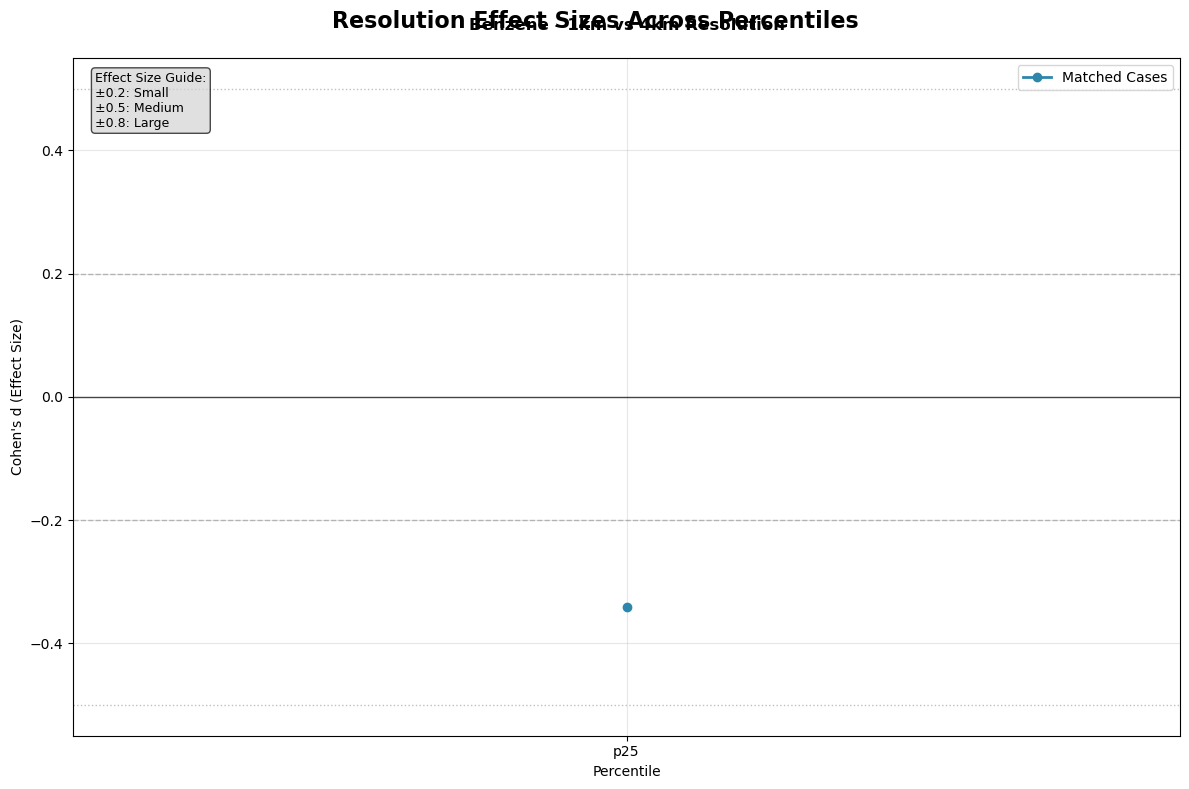

Effect size plot saved to: ip1_3bv1_peopleair\ip1_3bv1_peopleair_benzene_effect_sizes_by_percentile.png


In [41]:

# Create the effect size plot using both DataFrames
fig_effect_sizes = plot_effect_sizes_by_percentile(
    results_multi_species, 
    programname=programname,
    save_plot=True
)

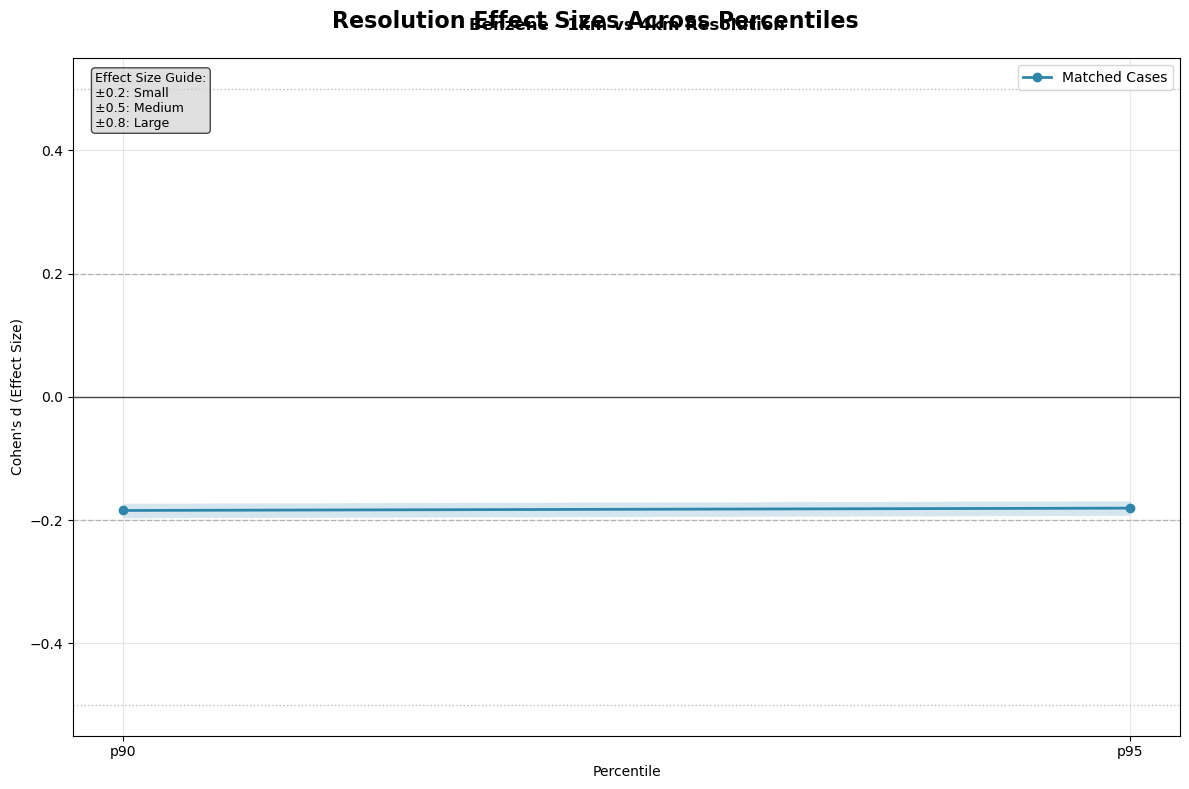

Effect size plot saved to: ip1_3bv1_peopleair\ip1_3bv1_peopleair_benzene_effect_sizes_by_percentile.png


In [42]:
# Create the effect size plot using both DataFrames
fig_effect_sizes = plot_effect_sizes_by_percentile(
    results_ownership, 
    programname=programname,
    save_plot=True
)

In [ ]:
# all data
results_all = compare_resolution_anova(hua_ari_df, 'Benzene', 'p100', matched_cases_only=False)

print("\n" + "="*80)

# matched cases only
results_matched = compare_resolution_anova(hua_ari_df, 'Benzene', 'p100', matched_cases_only=True)

In [ ]:
# Function to create combined box plot for any species percentiles comparing 1km and 4km resolutions
import matplotlib.pyplot as plt
import numpy as np

def create_species_percentiles_comparison_plot(hua_ari_df, 
                                               species_name, 
                                               programname, 
                                               figsize=(15, 8), 
                                               save_plot=True, 
                                               matched_cases_only=False):
    """
    Create a combined box plot comparing 1km and 4km resolutions for all percentiles of a given species
    
    Parameters:
    - hua_ari_df: DataFrame with air pollution and housing data
    - species_name: Name of the species to analyze (e.g., 'Benzene', 'NOx', 'PM2.5')
    - programname: Program name for saving files
    - figsize: Figure size tuple (width, height)
    - save_plot: Whether to save the plot to file
    - matched_cases_only: If True, only compare housing units that have valid data in both resolutions
    
    Returns:
    - fig: matplotlib figure object (if plot created successfully)
    """
    
    # Find all species columns for both resolutions
    species_1km_cols = [col for col in hua_ari_df.columns if f'uifl_1km_{species_name}_p' in col]
    species_4km_cols = [col for col in hua_ari_df.columns if f'uifl_4km_{species_name}_p' in col]
    
    # Extract percentile numbers and sort them
    percentiles_1km = []
    percentiles_4km = []
    
    for col in species_1km_cols:
        parts = col.split('_')
        if len(parts) >= 4 and parts[3].startswith('p'):
            percentile = int(parts[3][1:])  # Remove 'p' and convert to int
            percentiles_1km.append((percentile, col))
    
    for col in species_4km_cols:
        parts = col.split('_')
        if len(parts) >= 4 and parts[3].startswith('p'):
            percentile = int(parts[3][1:])  # Remove 'p' and convert to int
            percentiles_4km.append((percentile, col))
    
    # Sort by percentile value
    percentiles_1km.sort()
    percentiles_4km.sort()
    
    # Find common percentiles
    common_percentiles = []
    for p1, col1 in percentiles_1km:
        for p2, col2 in percentiles_4km:
            if p1 == p2:
                common_percentiles.append((p1, col1, col2))
    
    
    if len(common_percentiles) > 0:
        # Create single plot with grouped box plots
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Prepare data for all percentiles
        all_data_1km = []
        all_data_4km = []
        percentile_labels = []
        
        for percentile, col_1km, col_4km in common_percentiles:
            # Extract data for this percentile
            if matched_cases_only:
                # Only include cases that have valid data in both resolutions
                valid_both = (hua_ari_df[col_1km] > 0) & (hua_ari_df[col_4km] > 0) & \
                           hua_ari_df[col_1km].notna() & hua_ari_df[col_4km].notna()
                data_1km = hua_ari_df[valid_both][col_1km]
                data_4km = hua_ari_df[valid_both][col_4km]
            else:
                # Independent filtering for each resolution (original behavior)
                data_1km = hua_ari_df[hua_ari_df[col_1km] > 0][col_1km].dropna()
                data_4km = hua_ari_df[hua_ari_df[col_4km] > 0][col_4km].dropna()
            
            all_data_1km.append(data_1km)
            all_data_4km.append(data_4km)
            percentile_labels.append(f'p{percentile}')
        
        # Calculate positions for grouped box plots
        n_percentiles = len(common_percentiles)
        positions_1km = np.arange(1, 2*n_percentiles, 2)  # 1, 3, 5, 7, ...
        positions_4km = np.arange(2, 2*n_percentiles+1, 2)  # 2, 4, 6, 8, ...
        
        # Create box plots for 1km data
        bp1 = ax.boxplot(all_data_1km, positions=positions_1km, widths=0.6, patch_artist=True,
                         flierprops=dict(marker='o', alpha=0.5, markersize=2))
        
        # Create box plots for 4km data  
        bp2 = ax.boxplot(all_data_4km, positions=positions_4km, widths=0.6, patch_artist=True,
                         flierprops=dict(marker='o', alpha=0.5, markersize=2))
        
        # Color the boxes
        for box in bp1['boxes']:
            box.set_facecolor('lightblue')
            box.set_edgecolor('blue')
        
        for box in bp2['boxes']:
            box.set_facecolor('lightcoral')
            box.set_edgecolor('red')
        
        # Color the medians
        for median in bp1['medians'] + bp2['medians']:
            median.set_color('darkred')
            median.set_linewidth(2)
        
        # Set x-axis labels at the center of each pair
        tick_positions = (positions_1km + positions_4km) / 2
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(percentile_labels)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='lightblue', edgecolor='blue', label='1km Resolution'),
                          Patch(facecolor='lightcoral', edgecolor='red', label='4km Resolution')]
        ax.legend(handles=legend_elements, loc='upper right')
        
        ax.set_title(f'{species_name} Concentrations by Percentile and Resolution', fontsize=16, fontweight='bold')
        ax.set_xlabel('Percentiles', fontsize=12)
        ax.set_ylabel('Concentration (ppb)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, axis='y', alpha=0.3)
        
        # Add housing unit counts as text at bottom of chart
        if len(common_percentiles) > 0:
            first_percentile, col_1km_first, col_4km_first = common_percentiles[0]
            
            if matched_cases_only:
                valid_both = (hua_ari_df[col_1km_first] > 0) & (hua_ari_df[col_4km_first] > 0) & \
                           hua_ari_df[col_1km_first].notna() & hua_ari_df[col_4km_first].notna()
                matched_count = valid_both.sum()
                note_text = f"Note: Matched cases only - {matched_count:,} housing units with valid data in both resolutions"
            else:
                data_1km_total = hua_ari_df[hua_ari_df[col_1km_first] > 0][col_1km_first].dropna()
                data_4km_total = hua_ari_df[hua_ari_df[col_4km_first] > 0][col_4km_first].dropna()
                note_text = f"Note: 1km resolution - {len(data_1km_total):,} housing units; 4km resolution - {len(data_4km_total):,} housing units"
            
            ax.text(0.5, -0.12, note_text, transform=ax.transAxes, ha='center', va='top',
                    fontsize=10, style='italic', bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
        
        # Save plot if requested
        if save_plot:
            import os
            if not os.path.exists(programname):
                os.makedirs(programname)
            
            suffix = "_matched" if matched_cases_only else ""
            filename = f"{programname}_{species_name.lower()}_percentiles_comparison{suffix}.png"
            filepath = os.path.join(programname, filename)
            fig.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
            #print(f"{species_name} percentiles comparison plot saved to: {filepath}")
        
        return fig
        
    else:
        #print(f"No common percentiles found between 1km and 4km {species_name} data")
        return None

# Example usage: Create plot for Benzene (all available data)
fig_benzene = create_species_percentiles_comparison_plot(
    hua_ari_df, 'Benzene', programname, save_plot=True
)

# Example usage: Create plot for Benzene (matched cases only)
fig_benzene_matched = create_species_percentiles_comparison_plot(
    hua_ari_df, 'Benzene', programname, save_plot=True, matched_cases_only=True
)


In [ ]:
# Example usage: Create plot for Benzene (all available data)
fig_styrene = create_species_percentiles_comparison_plot(
    hua_ari_df, 'Styrene', programname, save_plot=True
)

# Example usage: Create plot for Benzene (matched cases only)
fig_styrene_matched = create_species_percentiles_comparison_plot(
    hua_ari_df, 'Styrene', programname, save_plot=True, matched_cases_only=True
)

In [ ]:
# Example usage: Create plot for Benzene (all available data)
fig_ethylene_oxide = create_species_percentiles_comparison_plot(
    hua_ari_df, 'Ethylene Oxide', programname, save_plot=True
)

# Example usage: Create plot for Benzene (matched cases only)
fig_ethylene_oxide_matched = create_species_percentiles_comparison_plot(
    hua_ari_df, 'Ethylene Oxide', programname, save_plot=True, matched_cases_only=True
)

Summary of methods from MS Copilot Auto LLM selection

### Version 1: Academic Journal Audience
#### Title: Assessing Ownership-Based Disparities in Air Pollution Exposure Across Distributional Percentiles
#### Summary:
To evaluate whether disparities in air pollution exposure between owner-occupied and renter-occupied housing units vary across the exposure distribution, we computed standardized mean differences (Cohen’s d) at multiple percentiles (p25, p50, p75, p90) of modeled benzene concentrations. This approach moves beyond a single summary statistic (e.g., mean or p90) to capture potential heterogeneity in disparities at higher exposure levels, which are often more relevant for health risk assessment. Effect sizes were plotted against percentiles to visualize trends, providing insight into whether ownership-related differences amplify in the upper tail of the distribution. This method complements traditional ANOVA by emphasizing practical significance and distributional equity rather than relying solely on p-values, which can be misleading in large samples.

### Version 2: Community Decision Makers (No Statistical Background)
#### Title: Looking at Pollution Differences Where It Matters Most
#### Summary:
Instead of just comparing average pollution levels between homeowners and renters, we looked at different points in the pollution range—from typical levels to the highest levels people experience. This helps us see if renters face bigger differences when pollution is at its worst. We measured the size of the gap at each point and made a simple chart showing whether the gap grows as pollution gets higher. This approach focuses on real-world impact: even if overall differences are small, renters might still be more exposed in the most polluted areas, which is important for health and fairness.